# Introduction

Pour atteindre son objectif de ville neutre en émissions de carbone en 2050, la ville de <strong>Seattle</strong> s’intéresse de près aux émissions des bâtiments non destinés à l’habitation.
L'objectif de ce projet est double :
<ol>
    <li>Construire un modèle optimisé pour la prédiction des <strong>émissions de CO2</strong> et la <strong>consommation totale d’énergie</strong> de bâtiments pour lesquels elles n’ont pas encore été mesurées, sur la base des :    
     <ul>
         <li>relevés effectués en 2015 et en 2016 ;</li>
         <li>données déclaratives du permis d'exploitation commerciale (taille et usage des bâtiments, mention de travaux récents, date de construction..) ;</li>
     </ul></li>
    <li>également à évaluer l’intérêt de l’<strong>ENERGYSTARScore</strong> pour la prédiction d’émissions, qui est fastidieux à calculer avec l’approche utilisée actuellement.</li>
</ol>

Ce premier notebook vise l’analyse exploratoire des données disponibles, les nettoyer, agréger et produire un data set propre et exploitable par la partie apprentissage des modèles (second notebook).

# 0- Initialisation

In [1]:
# Librairies personnalisées
from my_functions.common_functions import *
from my_functions.uni_bi_variate_functions import *
from my_functions.machine_learning_common_functions import *
from my_functions.pca_functions import *

from sklearn.experimental import enable_iterative_imputer 
from sklearn.impute import KNNImputer, IterativeImputer

from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

%matplotlib inline

low_memory=False # faible mémoire vive (RAM) pour gérer la lecture de gros fichiers

In [2]:
# Chargement des Data Sets
df15 = pd.read_csv('2015-building-energy-benchmarking.csv', low_memory=low_memory)
df16 = pd.read_csv('2016-building-energy-benchmarking.csv', low_memory=low_memory)

Le data set contient :
	- 3340 lignes et 47 colonnes.
	- 26512 valeurs manquantes, ce qui représente 16.89 % du data set.
Voici un sous-échantillon aléatoire :


,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,TaxParcelIdentificationNumber,Location,CouncilDistrictCode,Neighborhood,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ListOfAllPropertyUseTypes,LargestPropertyUseType,LargestPropertyUseTypeGFA,SecondLargestPropertyUseType,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseType,ThirdLargestPropertyUseTypeGFA,YearsENERGYSTARCertified,ENERGYSTARScore,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),OtherFuelUse(kBtu),GHGEmissions(MetricTonsCO2e),GHGEmissionsIntensity(kgCO2e/ft2),DefaultData,Comment,ComplianceStatus,Outlier,2010 Census Tracts,Seattle Police Department Micro Community Policing Plan Areas,City Council Districts,SPD Beats,Zip Codes
1658,22943,2015,Multifamily LR (1-4),Low-Rise Multifamily,NORTH COURT APTS,2926049023,"{'latitude': '47.70546173', 'longitude': '-122...",5,NORTHWEST,1986,1,4.0,123841,42380,81461,Multifamily Housing,Multifamily Housing,81462.0,NaN,NaN,NaN,NaN,NaN,69.0,31.7,33.2,95.5,99.8,2584082.0,2705438.0,0.0,709918.0,2422342.0,1618.0,161840.0,0.0,25.48,0.12,No,NaN,Compliant,NaN,NaN,46.0,NaN,34.0,19582
3027,27744,2015,Multifamily LR (1-4),Mixed Use Property,FREMONT COURT APTS,5694000240,"{'latitude': '47.66124886', 'longitude': '-122...",6,LAKE UNION,1990,1,4.0,45111,15056,30055,"Multifamily Housing, Other, Parking, Urgent Ca...",Multifamily Housing,17924.0,Parking,15056.0,Other,5510.0,NaN,NaN,37.2,41.1,116.9,128.9,936336.0,1032932.0,0.0,274425.0,936375.0,0.0,0.0,0.0,6.53,0.06,No,NaN,Compliant,NaN,NaN,20.0,NaN,2.0,18377


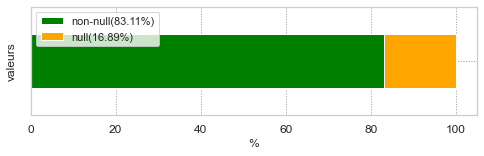

In [3]:
# Vérification de la structure du Data Set
verifier_taille(df15)
afficher_echantillon(df15)

Le data set contient :
	- 3376 lignes et 46 colonnes.
	- 19952 valeurs manquantes, ce qui représente 12.85 % du data set.
Voici un sous-échantillon aléatoire :


,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,Address,City,State,ZipCode,TaxParcelIdentificationNumber,CouncilDistrictCode,Neighborhood,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ListOfAllPropertyUseTypes,LargestPropertyUseType,LargestPropertyUseTypeGFA,SecondLargestPropertyUseType,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseType,ThirdLargestPropertyUseTypeGFA,YearsENERGYSTARCertified,ENERGYSTARScore,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),DefaultData,Comments,ComplianceStatus,Outlier,TotalGHGEmissions,GHGEmissionsIntensity
768,19833,2016,NonResidential,University,Centennial Building,2000 Terry Avenue,Seattle,WA,98121.0,0660001445,7,DOWNTOWN,47.61741,-122.33491,1992,1.0,2,28923,0,28923,College/University,College/University,28800.0,NaN,NaN,NaN,NaN,NaN,NaN,15.3,17.700001,28.700001,31.799999,439311.9063,508430.5938,0.0,51221.50000,174768.0,2645.440186,264544.0,False,NaN,Compliant,NaN,15.27,0.53
2402,25537,2016,NonResidential,Self-Storage Facility,FremontBridgeMini,319 Nickerson St,Seattle,WA,98109.0,5244800055,7,MAGNOLIA / QUEEN ANNE,47.64633,-122.35080,1918,1.0,2,28309,0,28309,Self-Storage Facility,Self-Storage Facility,28309.0,NaN,NaN,NaN,NaN,NaN,NaN,15.2,17.600000,33.599998,36.500000,430308.9063,498364.9063,0.0,69894.70313,238481.0,1918.280273,191828.0,False,NaN,Compliant,NaN,11.85,0.42


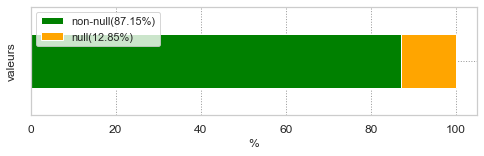

In [4]:
# Vérification de la structure du Data Set
verifier_taille(df16)
afficher_echantillon(df16)

# 1- Nettoyage des Données

Dans cette section, les deux data sets sont agrégés et nettoyés pour produire un data set unique exploitable dans la suite du projet.

## 1.1- Filtrage Colonnes

D’abord on restreint les data sets 2015 et 2016 aux colonnes pertinentes pour la problématique, puis leurs structures sont harmonisées afin de les agréger.
<br/>
<strong><em>À noter :</em></strong> une colonne pertinente représente une information nécessaire ou importante pour la construction des modèles prédictifs.

### 1.1.1- Colonnes Vides

Les colonnes avec le plus de valeurs manquantes sont identifiées. Les colonnes les plus pertinente seront gardées et leurs valeurs manquantes traitées dans la suite de ce processus de nettoyage.

In [5]:
nan_cols(df15, 1) # Affichage des colonnes vides trouvées

,Column,#NaN,%NaN,#Not_NaN,%Not_NaN
0,ListOfAllPropertyUseTypes,127,3.80,3213,96.20
1,LargestPropertyUseType,136,4.07,3204,95.93
2,LargestPropertyUseTypeGFA,136,4.07,3204,95.93
3,SecondLargestPropertyUseType,1781,53.32,1559,46.68
4,SecondLargestPropertyUseTypeGFA,1781,53.32,1559,46.68
5,ThirdLargestPropertyUseType,2780,83.23,560,16.77
6,ThirdLargestPropertyUseTypeGFA,2780,83.23,560,16.77
7,YearsENERGYSTARCertified,3230,96.71,110,3.29
8,ENERGYSTARScore,780,23.35,2560,76.65
9,Comment,3327,99.61,13,0.39


In [6]:
nan_cols(df16, 1) # Affichage des colonnes vides trouvées

,Column,#NaN,%NaN,#Not_NaN,%Not_NaN
0,SecondLargestPropertyUseType,1697,50.27,1679,49.73
1,SecondLargestPropertyUseTypeGFA,1697,50.27,1679,49.73
2,ThirdLargestPropertyUseType,2780,82.35,596,17.65
3,ThirdLargestPropertyUseTypeGFA,2780,82.35,596,17.65
4,YearsENERGYSTARCertified,3257,96.48,119,3.52
5,ENERGYSTARScore,843,24.97,2533,75.03
6,Comments,3376,100.00,0,0.00
7,Outlier,3344,99.05,32,0.95


Les colonnes <strong>LargestPropertyUseType</strong>, <strong>LargestPropertyUseTypeGFA</strong>, <strong>ENERGYSTARScore</strong> représentent des informations importantes pour la problématique. Ainsi, ces colonnes seront sélectionnées et leurs valeurs manquantes imputées.

### 1.1.2- Restriction aux Colonnes Pertinentes

Sélection et restriction aux colonnes pertinentes sur les data sets 2015 et 2016.

In [7]:
# Sélection des colonnes considérées pertinentes pour l’apprentissage des modèles prédictifs 
Cols = ['OSEBuildingID', 'BuildingType', 'PrimaryPropertyType', 'PropertyGFATotal', 'LargestPropertyUseType', 'SteamUse(kBtu)', 'Electricity(kBtu)', 'NaturalGas(kBtu)', 'ENERGYSTARScore', 'SiteEnergyUseWN(kBtu)', 'GHGEmissions(MetricTonsCO2e)', 'Neighborhood', 'CouncilDistrictCode', 'YearBuilt', 'NumberofBuildings', 'NumberofFloors', 'ComplianceStatus']
# Restriction du data set aux colonnes sélectionnées
df15s = df15[Cols] 
# Renommer les colonnes pour les harmoniser avec le data set 2016
df15s = renameCol(df15s, 'SteamUse(kBtu)', 'SteamUse')
df15s = renameCol(df15s, 'Electricity(kBtu)', 'Electricity')
df15s = renameCol(df15s, 'NaturalGas(kBtu)', 'NaturalGas')
df15s = renameCol(df15s, 'SiteEnergyUseWN(kBtu)', 'TotalEnergy_2015')
df15s = renameCol(df15s, 'GHGEmissions(MetricTonsCO2e)', 'TotalEmission_2015')

df15s.head(2)

,OSEBuildingID,BuildingType,PrimaryPropertyType,PropertyGFATotal,LargestPropertyUseType,SteamUse,Electricity,NaturalGas,ENERGYSTARScore,TotalEnergy_2015,TotalEmission_2015,Neighborhood,CouncilDistrictCode,YearBuilt,NumberofBuildings,NumberofFloors,ComplianceStatus
0,1,NonResidential,Hotel,88434,Hotel,2023032.0,3686160.0,1272388.0,65.0,7097539.0,249.43,DOWNTOWN,7,1927,1,12.0,Compliant
1,2,NonResidential,Hotel,103566,Hotel,0.0,3905411.0,4448985.0,51.0,8765788.0,263.51,DOWNTOWN,7,1996,1,11.0,Compliant


In [8]:
# Sélection des colonnes considérées pertinentes pour l’apprentissage des modèles prédictifs 
Cols = ['OSEBuildingID', 'BuildingType', 'PrimaryPropertyType',	'PropertyGFATotal', 'LargestPropertyUseType', 'SteamUse(kBtu)', 'Electricity(kBtu)', 'NaturalGas(kBtu)', 'ENERGYSTARScore', 'SiteEnergyUseWN(kBtu)', 'TotalGHGEmissions', 'Neighborhood', 'CouncilDistrictCode', 'YearBuilt', 'NumberofBuildings', 'NumberofFloors', 'ComplianceStatus']
# Restriction du data set aux colonnes sélectionnées
df16s = df16[Cols]
# Renommer les colonnes pour les harmoniser avec le data set 2015
df16s = renameCol(df16s, 'SteamUse(kBtu)', 'SteamUse')
df16s = renameCol(df16s, 'Electricity(kBtu)', 'Electricity')
df16s = renameCol(df16s, 'NaturalGas(kBtu)', 'NaturalGas')
df16s = renameCol(df16s, 'SiteEnergyUseWN(kBtu)', 'TotalEnergy_2016')
df16s = renameCol(df16s, 'TotalGHGEmissions', 'TotalEmission_2016')

df16s.head(2)

,OSEBuildingID,BuildingType,PrimaryPropertyType,PropertyGFATotal,LargestPropertyUseType,SteamUse,Electricity,NaturalGas,ENERGYSTARScore,TotalEnergy_2016,TotalEmission_2016,Neighborhood,CouncilDistrictCode,YearBuilt,NumberofBuildings,NumberofFloors,ComplianceStatus
0,1,NonResidential,Hotel,88434,Hotel,2003882.0,3946027.0,1276453.0,60.0,7456910.0,249.98,DOWNTOWN,7,1927,1.0,12,Compliant
1,2,NonResidential,Hotel,103566,Hotel,0.0,3242851.0,5145082.0,61.0,8664479.0,295.86,DOWNTOWN,7,1996,1.0,11,Compliant


<strong>À Noter !</strong> pour les données de consommation d'énergie et d'émission de CO2, on sélection les versions normalisées par rapport à la météo, <strong><em>Weather Normalized (WN)</em></strong>, pour ignorer l'impact de la météo et se concentrer uniquement sur les caractéristiques des bâtiments et produire des modèles plus généralistes.

## 1.2- Agrégation des Données 2015 & 2016

L’agrégation des data sets 2015 et 2016 se produit en deux temps :  accoler les données 2015 aux bâtiments présents en 2016 (jointure gauche de 2016 avec 2015 sur l’identifiant des bâtiments <strong>OSEBuildingID</strong>), puis ajouter les bâtiments présents en 2015 et pas en 2016.
<br/>
Ensuite, les valeurs de <strong>TotalEnergy</strong> et <strong>TotalEmission</strong> sur les deux années sont agrégées avec la médiane et les anciennes valeurs (colonnes) sont supprimées.

Le data set contient :
	- 3432 lignes et 17 colonnes.
	- 939 valeurs manquantes, ce qui représente 1.61 % du data set.
Voici un sous-échantillon aléatoire :


,OSEBuildingID,BuildingType,PrimaryPropertyType,PropertyGFATotal,LargestPropertyUseType,SteamUse,Electricity,NaturalGas,ENERGYSTARScore,Neighborhood,CouncilDistrictCode,YearBuilt,NumberofBuildings,NumberofFloors,ComplianceStatus,TotalEnergy,TotalEmission
1918,23815,Multifamily MR (5-9),Mid-Rise Multifamily,87041,Multifamily Housing,0.0,2003948.0,0.0,64.0,CENTRAL,3,2008,1.0,6.0,Error - Correct Default Data,2.064411e+06,13.835
1678,23098,NonResidential,Supermarket / Grocery Store,21603,Supermarket/Grocery Store,0.0,3900058.0,1933742.0,16.0,GREATER DUWAMISH,2,1965,1.0,1.0,Compliant,5.947557e+06,124.730


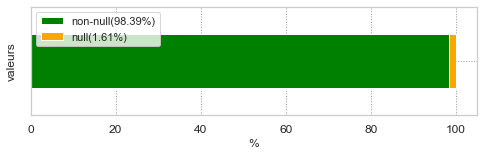

In [9]:
# Jointure des data sets 2015 & 2016 
df = pd.merge(df16s, df15s[['OSEBuildingID', 'TotalEnergy_2015', 'TotalEmission_2015']], how='left', on=['OSEBuildingID'])
df = pd.concat([df, df15s[~df15s['OSEBuildingID'].isin(df16s['OSEBuildingID'])]], axis=0)

# Agrégation des colonnes TotalEnergy & TotalEmission de 2015 & 2016 grâce à la médiane
df['TotalEnergy'] = df[['TotalEnergy_2015','TotalEnergy_2016']].median(axis=1)
df['TotalEmission'] = df[['TotalEmission_2015','TotalEmission_2016']].median(axis=1)

# Supprimer les anciennes colonnes
df = df.drop(columns=['TotalEnergy_2015', 'TotalEmission_2015', 'TotalEnergy_2016', 'TotalEmission_2016'])
# Réindexer les lignes pour éviter les doublons d'index
df = df.reset_index(drop=True)

verifier_taille(df)
afficher_echantillon(df)

Le nombre total des bâtiments est légèrement supérieur au nombre de bâtiments dans chaque année, car certains sont présents dans une année et pas dans l'autre.
<br/>
À ce stade, nous obtenons un seul data set contenant les informations essentielles sur les bâtiments en 2015 et 2016, ce qui a comme résultat la réduction du taux des valeurs manquantes.

## 1.3- Nettoyage des Catégories

Les colonnes catégorielles sont passées en revue pour identifier de potentielles anomalies dans leurs valeurs et les corriger.

In [10]:
# Affichage des colonnes de type catégorie
categories = colsOfType(df, 'object')
categories

['BuildingType',
 'PrimaryPropertyType',
 'LargestPropertyUseType',
 'Neighborhood',
 'ComplianceStatus']

In [11]:
# Affichage des valeurs de chaque catégories
for categorie in categories[:-1]:
    print('------------', categorie, '------------')
    print(df[categorie].sort_values().unique())

------------ BuildingType ------------
['Campus' 'Multifamily HR (10+)' 'Multifamily LR (1-4)'
 'Multifamily MR (5-9)' 'NonResidential' 'Nonresidential COS'
 'Nonresidential WA' 'SPS-District K-12']
------------ PrimaryPropertyType ------------
['Distribution Center' 'High-Rise Multifamily' 'Hospital' 'Hotel'
 'K-12 School' 'Laboratory' 'Large Office' 'Low-Rise Multifamily'
 'Medical Office' 'Mid-Rise Multifamily' 'Mixed Use Property'
 'Non-Refrigerated Warehouse' 'Office' 'Other' 'Refrigerated Warehouse'
 'Residence Hall' 'Restaurant' 'Restaurant\n' 'Retail Store'
 'Self-Storage Facility' 'Senior Care Community'
 'Small- and Mid-Sized Office' 'Supermarket / Grocery Store' 'University'
 'Warehouse' 'Worship Facility']
------------ LargestPropertyUseType ------------
['Adult Education' 'Automobile Dealership' 'Bank Branch'
 'College/University' 'Convention Center' 'Courthouse' 'Data Center'
 'Distribution Center' 'Financial Office' 'Fire Station'
 'Fitness Center/Health Club/Gym' 'Food 

Il y a 3 anomalies dans les valeurs des catégories : 
<ul>
    <li><strong>PrimaryPropertyType</strong> contient 'Restaurant\n' et 'Restaurant' ;</li>
    <li><strong>LargestPropertyUseType</strong> contient nan ;</li>
    <li><strong>Neighborhood</strong> contient des valeurs en double avec des casses différentes.</li>
</ul>
De plus, <strong>PrimaryPropertyType</strong> est incluse dans <strong>LargestPropertyUseType</strong>. Autrement dit, <strong>LargestPropertyUseType</strong> est plus informative et pertinente que <strong>PrimaryPropertyType</strong>, ce qui rend cette dernière inutile.
<br/>
<br/>
Le processus de correction des catégories se déroule comme suit : 
<ol>
    <li>correction de <strong>PrimaryPropertyType</strong> pour l’exploiter à l’imputation de <strong>LargestPropertyUseType</strong> ;</li>
    <li>Suppression de <strong>PrimaryPropertyType</strong> ;</li>
    <li>Harmoniser la casse de <strong>Neighborhood</strong> ;</li>
</ol>


In [158]:
# Correction de la valeur "Restaurant\n" dans la colonne PrimaryPropertyType
df['PrimaryPropertyType'] = df['PrimaryPropertyType'].replace('Restaurant\n', 'Restaurant')
df['PrimaryPropertyType'].sort_values().unique()

array(['Distribution Center', 'High-Rise Multifamily', 'Hospital',
       'Hotel', 'K-12 School', 'Laboratory', 'Large Office',
       'Low-Rise Multifamily', 'Medical Office', 'Mid-Rise Multifamily',
       'Mixed Use Property', 'Non-Refrigerated Warehouse', 'Office',
       'Other', 'Refrigerated Warehouse', 'Residence Hall', 'Restaurant',
       'Retail Store', 'Self-Storage Facility', 'Senior Care Community',
       'Small- and Mid-Sized Office', 'Supermarket / Grocery Store',
       'University', 'Warehouse', 'Worship Facility'], dtype=object)

In [159]:
# Remplacer chaquz nan dans LargestPropertyUseType avec la valeur dans PrimaryPropertyType sur la même ligne
nan_index = df[df['LargestPropertyUseType'].isnull()].index
nan_index
df.iloc[nan_index, df.columns.get_loc('LargestPropertyUseType')] = df.iloc[nan_index, df.columns.get_loc('PrimaryPropertyType')]

df['LargestPropertyUseType'].sort_values().unique()

array(['Adult Education', 'Automobile Dealership', 'Bank Branch',
       'College/University', 'Convention Center', 'Courthouse',
       'Data Center', 'Distribution Center', 'Financial Office',
       'Fire Station', 'Fitness Center/Health Club/Gym', 'Food Service',
       'High-Rise Multifamily', 'Hospital (General Medical & Surgical)',
       'Hotel', 'K-12 School', 'Laboratory', 'Library',
       'Lifestyle Center', 'Low-Rise Multifamily',
       'Manufacturing/Industrial Plant', 'Medical Office',
       'Mid-Rise Multifamily', 'Mixed Use Property', 'Movie Theater',
       'Multifamily Housing', 'Museum', 'Non-Refrigerated Warehouse',
       'Office', 'Other', 'Other - Education',
       'Other - Entertainment/Public Assembly',
       'Other - Lodging/Residential', 'Other - Mall',
       'Other - Public Services', 'Other - Recreation',
       'Other - Restaurant/Bar', 'Other - Services', 'Other - Utility',
       'Other/Specialty Hospital',
       'Outpatient Rehabilitation/Physica

In [160]:
# Supprimer la colonne PrimaryPropertyType
df = df.drop(columns=['PrimaryPropertyType'])

In [161]:
# Harmoniser la casse de Neighborhood
df['Neighborhood'] = df['Neighborhood'].str.capitalize()
df['Neighborhood'].sort_values().unique()

array(['Ballard', 'Central', 'Delridge', 'Delridge neighborhoods',
       'Downtown', 'East', 'Greater duwamish', 'Lake union',
       'Magnolia / queen anne', 'North', 'Northeast', 'Northwest',
       'Southeast', 'Southwest'], dtype=object)

## 1.4- Filtrage Lignes

La prochaine étape du nettoyage des données est le nettoyage des bâtiments par : suppression des potentiels doublons, traitement des valeurs manquantes, suppression des bâtiments non conformes.

### 1.4.1- Doublons

Recherche la présence de doublons dans le data set.

In [162]:
doublons(df['OSEBuildingID'])

Series([], Name: OSEBuildingID, dtype: int64)

In [163]:
doublons(df[df.columns.tolist()[1:]])

,BuildingType,PropertyGFATotal,LargestPropertyUseType,SteamUse,Electricity,NaturalGas,ENERGYSTARScore,Neighborhood,CouncilDistrictCode,YearBuilt,NumberofBuildings,NumberofFloors,ComplianceStatus,TotalEnergy,TotalEmission


Aucun doublon trouvé.

### 1.4.2- Imputation des Valeurs Manquantes

On utilise l'imputation par KNN pour renseigner les valeurs manquantes, après les avoir identifiées.

#### 1.4.2.1- Recherche des Valeurs Manquantes

Rechercher les colonnes avec des valeurs manquantes.

In [164]:
nan_cols(df, 0.01)

,Column,#NaN,%NaN,#Not_NaN,%Not_NaN
0,SteamUse,10,0.29,3422,99.71
1,Electricity,10,0.29,3422,99.71
2,NaturalGas,10,0.29,3422,99.71
3,ENERGYSTARScore,858,25.00,2574,75.00
4,NumberofBuildings,8,0.23,3424,99.77
5,TotalEnergy,3,0.09,3429,99.91
6,TotalEmission,4,0.12,3428,99.88


On va imputer les valeurs manquantes de toutes les colonnes.

#### 1.4.2.2- Evaluation de l'Imputation

Avant de procéder à l'imputation des valeurs manquantes, on évalue cette imputation sur les données existantes de la colonne avec le plus de valeurs manquantes c-à-d. l'<strong>ENERGYSTARScore</strong>.

In [165]:
# Construction des train set et test set
df_ENERGYSTARScore = df[df['ENERGYSTARScore'].notnull()][colsOfType(df)[1:]]

data_size = len(df_ENERGYSTARScore)
test_sample_size = int(data_size*0.2)
test_sample = np.random.choice(data_size, size=test_sample_size, replace=False)
test_sample = sorted(test_sample)

test_data = df_ENERGYSTARScore.iloc[test_sample]['ENERGYSTARScore'].copy()
df_ENERGYSTARScore.iloc[test_sample, df.columns.get_loc('ENERGYSTARScore')] = np.nan

In [166]:
# Première Tentaive : KNNimputer
imp = KNNImputer(n_neighbors=5, weights='distance')
imputed_data = imp.fit_transform(df_ENERGYSTARScore)
error = np.sqrt((test_data - imputed_data[test_sample, df_ENERGYSTARScore.columns.get_loc('ENERGYSTARScore')])**2).mean()
print('KNNImputer error:', error)

KNNImputer error: 0.0


L'imputer KNN ne fait aucune erreur d'imputation, on peut donc passer à l'imputation réelle de toutes les valeurs manquantes.

#### 1.4.2.3- Imputation KNN

In [167]:
knn_imputer = KNNImputer(n_neighbors=10, weights='distance')
knn_imputer_transfom = knn_imputer.fit_transform(df[colsOfType(df)[1:]])
df[colsOfType(df)[1:]] = knn_imputer_transfom

### 1.4.4- Bâtiments Non Confomres

Eliminer les bâtiments considérés comme non conformes.

In [168]:
df[df['ComplianceStatus']=='Not Compliant']
df = df.drop(columns=['ComplianceStatus'])

Le data set contient :
	- 3432 lignes et 15 colonnes.
	- 0 valeurs manquantes, ce qui représente 0.0 % du data set.
Voici un sous-échantillon aléatoire :


,OSEBuildingID,BuildingType,PropertyGFATotal,LargestPropertyUseType,SteamUse,Electricity,NaturalGas,ENERGYSTARScore,Neighborhood,CouncilDistrictCode,YearBuilt,NumberofBuildings,NumberofFloors,TotalEnergy,TotalEmission
926,20251,Multifamily LR (1-4),24492.0,Multifamily Housing,0.0,585737.0,0.0,67.000000,Northeast,4.0,1981.0,1.0,3.0,6.412022e+05,4.05
1168,21142,NonResidential,30730.0,Other,0.0,1918002.0,1132453.0,69.680041,Lake union,6.0,1969.0,1.0,1.0,2.832687e+06,60.50


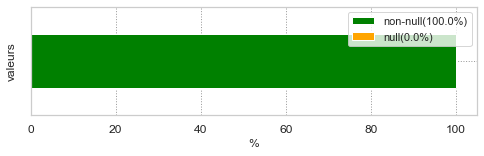

In [169]:
# Vérification de la structure du Data Set
verifier_taille(df)
afficher_echantillon(df)

Maintenant que le data set est nettoyé et renseigné, on passe à l'analyse exploratoire et préparation des données pour l'apprentissage.

# 2- Analyse & Transformation des Attributs

Dans un premier temps, analyser les attributs/features et éventuellement les transformer. Puis dans un second temps, analyser les colonnes à prédire (classes/targets).

In [170]:
# Distinguer les classes/targets des Attributs/features
classes = ['TotalEnergy', 'TotalEmission']
Attributs = df.columns.tolist()[1:]
for c in classes:
    Attributs.remove(c)
Attributs

['BuildingType',
 'PropertyGFATotal',
 'LargestPropertyUseType',
 'SteamUse',
 'Electricity',
 'NaturalGas',
 'ENERGYSTARScore',
 'Neighborhood',
 'CouncilDistrictCode',
 'YearBuilt',
 'NumberofBuildings',
 'NumberofFloors']

## 2.1- Distributions

Analyse de la distribution des attributs.

In [171]:
df[Attributs].describe()

,PropertyGFATotal,SteamUse,Electricity,NaturalGas,ENERGYSTARScore,CouncilDistrictCode,YearBuilt,NumberofBuildings,NumberofFloors
count,3.432000e+03,3.432000e+03,3.432000e+03,3.432000e+03,3432.000000,3432.000000,3432.000000,3432.000000,3432.000000
mean,9.458342e+04,2.768090e+05,3.703143e+06,1.376097e+06,68.185610,4.448135,1968.360140,1.106625,4.688228
std,2.176413e+05,3.892283e+06,1.477783e+07,6.785216e+06,23.995493,2.119483,33.182901,2.091119,5.458473
min,1.128500e+04,0.000000e+00,-1.154170e+05,0.000000e+00,1.000000,1.000000,1900.000000,0.000000,0.000000
25%,2.844600e+04,0.000000e+00,6.368348e+05,0.000000e+00,56.000000,3.000000,1948.000000,1.000000,2.000000
50%,4.409900e+04,0.000000e+00,1.174325e+06,3.139680e+05,73.000000,4.000000,1974.000000,1.000000,4.000000
75%,9.044875e+04,0.000000e+00,2.808759e+06,1.180110e+06,86.264094,7.000000,1997.000000,1.000000,5.000000
max,9.320156e+06,1.349435e+08,6.570744e+08,2.979090e+08,100.000000,7.000000,2015.000000,111.000000,99.000000


Le minimum de <strong>Electricity</strong> est négatif et le minimum de <strong>NumberofFloors</strong> est null. On recherche les bâtiments correspondants et corrige les valeurs correspondantes.

In [172]:
df.loc[(df['NumberofBuildings']<1)].sort_values(by=['NumberofBuildings'], ascending=False)

,OSEBuildingID,BuildingType,PropertyGFATotal,LargestPropertyUseType,SteamUse,Electricity,NaturalGas,ENERGYSTARScore,Neighborhood,CouncilDistrictCode,YearBuilt,NumberofBuildings,NumberofFloors,TotalEnergy,TotalEmission
758,19798,Multifamily LR (1-4),33166.0,Low-Rise Multifamily,0.0,8.306537e+05,3.566560e+05,73.748283,Northeast,4.0,1977.0,0.871054,3.0,1.275970e+06,24.534572
63,89,NonResidential,179014.0,Medical Office,0.0,9.886484e+06,6.814570e+06,48.000000,East,3.0,1965.0,0.000000,3.0,1.819308e+07,497.310000
2564,26119,NonResidential,24750.0,Retail Store,0.0,2.921180e+05,4.902260e+05,78.908337,East,3.0,1910.0,0.000000,2.0,9.699953e+05,28.665000
2511,25902,Multifamily MR (5-9),47321.0,Multifamily Housing,0.0,1.719773e+06,0.000000e+00,87.000000,Delridge,1.0,2009.0,0.000000,6.0,1.707684e+06,11.450000
2501,25866,Multifamily LR (1-4),26294.0,Multifamily Housing,0.0,5.773480e+05,0.000000e+00,89.000000,Magnolia / queen anne,7.0,1967.0,0.000000,4.0,6.636978e+05,4.230000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
985,20427,NonResidential,23315.0,Office,0.0,7.990290e+05,5.549710e+05,74.610949,Southwest,1.0,1926.0,0.000000,2.0,1.522123e+06,33.545000
979,20403,Multifamily LR (1-4),45320.0,Multifamily Housing,0.0,1.142232e+06,2.158317e+06,57.000000,Downtown,7.0,1916.0,0.000000,3.0,4.115167e+06,144.410000
952,20323,NonResidential,115775.0,Residence Hall/Dormitory,0.0,2.882489e+06,0.000000e+00,94.000000,East,3.0,1982.0,0.000000,15.0,3.089165e+06,20.125000
901,20186,Multifamily LR (1-4),31236.0,Multifamily Housing,0.0,9.171940e+05,0.000000e+00,76.000000,Southwest,1.0,1992.0,0.000000,4.0,9.748434e+05,6.365000


In [173]:
df[df['Electricity']<0]

,OSEBuildingID,BuildingType,PropertyGFATotal,LargestPropertyUseType,SteamUse,Electricity,NaturalGas,ENERGYSTARScore,Neighborhood,CouncilDistrictCode,YearBuilt,NumberofBuildings,NumberofFloors,TotalEnergy,TotalEmission
3206,49784,NonResidential,52000.0,Office,0.0,-115417.0,0.0,100.0,Central,3.0,2013.0,1.0,6.0,401305.5469,1.56


Il s'agit probalement d'erreurs de saisie, on les corrige.

In [174]:
# Metter NumberofBuildings à 1 
df.loc[(df['NumberofBuildings']<1), 'NumberofBuildings'] = 1

# Mettre Electricity en valeur absolue
df.loc[df['Electricity']<0, 'Electricity'] = np.abs(df.loc[df['Electricity']<0, 'Electricity'])

Réafficher les distributions.

In [175]:
df[Attributs].describe()

,PropertyGFATotal,SteamUse,Electricity,NaturalGas,ENERGYSTARScore,CouncilDistrictCode,YearBuilt,NumberofBuildings,NumberofFloors
count,3.432000e+03,3.432000e+03,3.432000e+03,3.432000e+03,3432.000000,3432.000000,3432.000000,3432.000000,3432.000000
mean,9.458342e+04,2.768090e+05,3.703211e+06,1.376097e+06,68.185610,4.448135,1968.360140,1.133469,4.688228
std,2.176413e+05,3.892283e+06,1.477781e+07,6.785216e+06,23.995493,2.119483,33.182901,2.083150,5.458473
min,1.128500e+04,0.000000e+00,0.000000e+00,0.000000e+00,1.000000,1.000000,1900.000000,1.000000,0.000000
25%,2.844600e+04,0.000000e+00,6.368348e+05,0.000000e+00,56.000000,3.000000,1948.000000,1.000000,2.000000
50%,4.409900e+04,0.000000e+00,1.174325e+06,3.139680e+05,73.000000,4.000000,1974.000000,1.000000,4.000000
75%,9.044875e+04,0.000000e+00,2.808759e+06,1.180110e+06,86.264094,7.000000,1997.000000,1.000000,5.000000
max,9.320156e+06,1.349435e+08,6.570744e+08,2.979090e+08,100.000000,7.000000,2015.000000,111.000000,99.000000


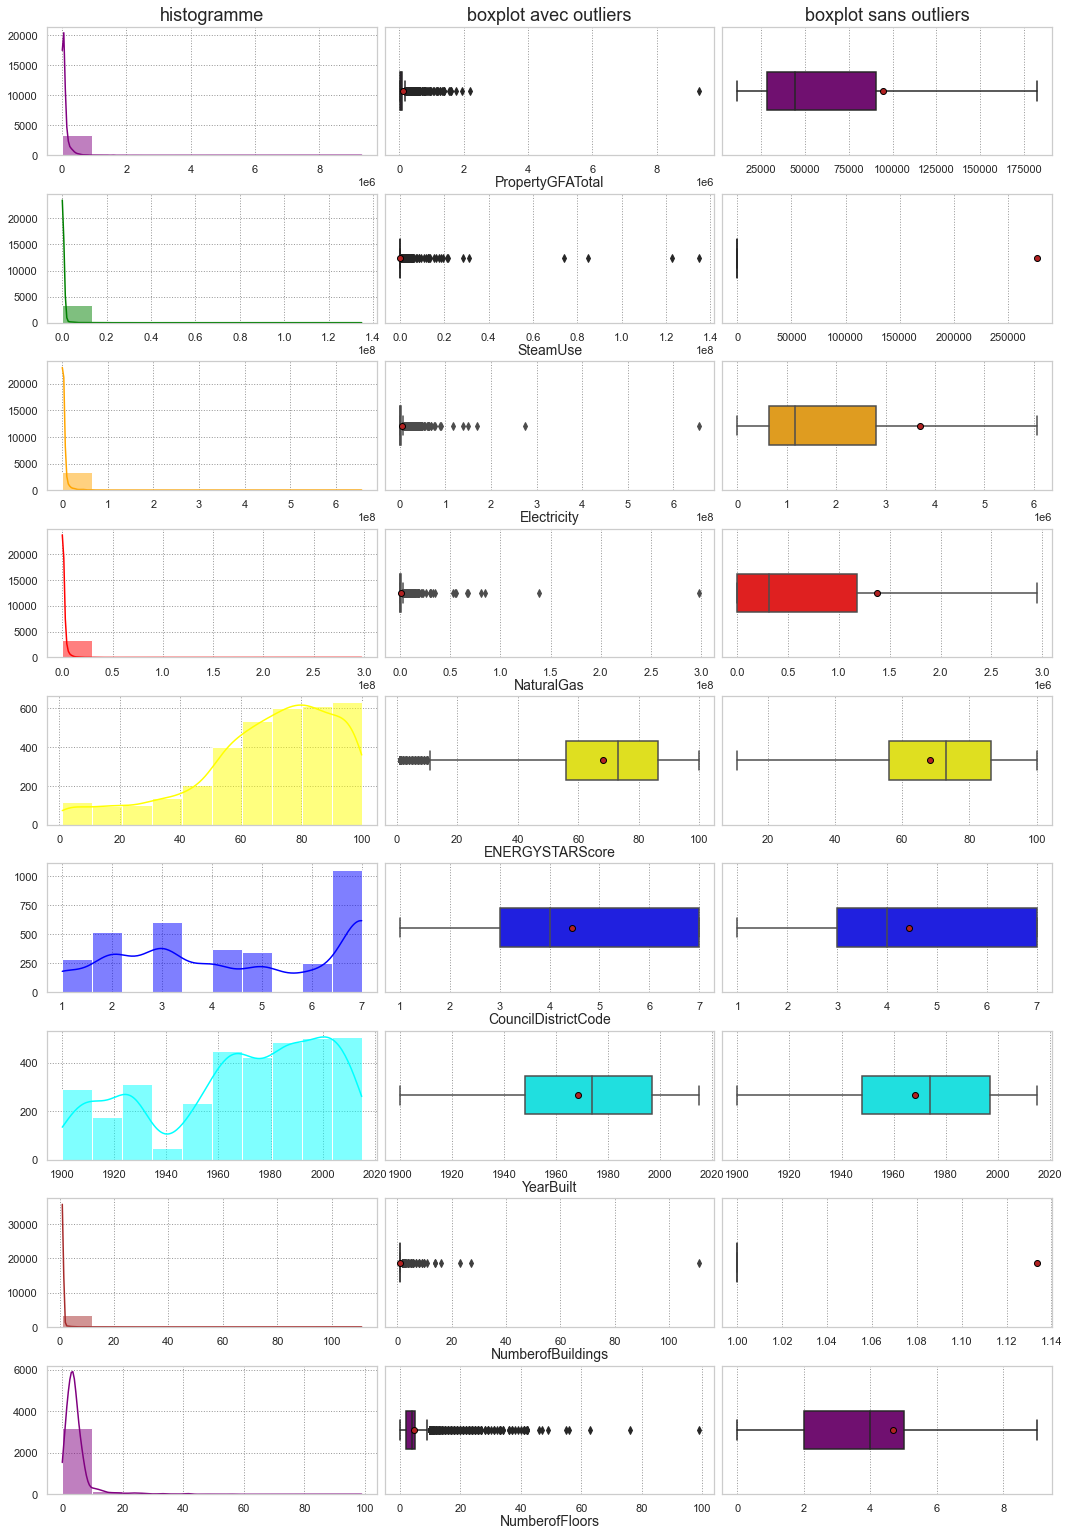

In [176]:
histo_distribution(df[Attributs])

Mis à part l'<strong>ENERGYSTARScore</strong>, <strong>CouncilDistrictCode</strong>, <strong>YearBuilt</strong>, les distributions des attributs sont asymétriques (strictement positives) et très concentrées sur les valeurs inférieures avec la présence de quelques individus/bâtiments avec de très grandes valeurs. Même si statistiquement ces bâtiments sont considérés comme des outliers, ce n'est pas nécessairement le cas pour notre problématique (à étudier dans la suite du projet).

## 2.2- Correlations

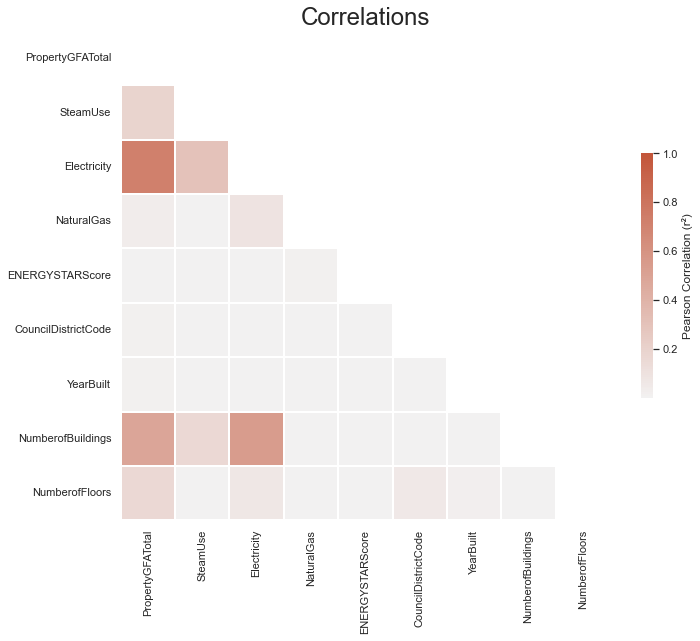

In [177]:
correlation_matrix(df[Attributs])

L'attribut est fortement corrélé à , il faudrait donc éliminer un des deux attributs pour réduire la complexité des futurs modèles. Or, dans cette situation il est préférable de garder les deux informations en effectuant une transformation pour éviter la correlation tout en gardant l'information utile sous-jacente (voir l'encodage plus bas).

## 2.3- CHi2

Etudier les relations possibles entre les attributs catégoriels.

### 2.3.1- BuildingType & LargestPropertyUseType

p-value is:  0.0
chi=7224.728782, critical value=476.177907
At 0.05 level of significance, we reject the null hypotheses and accept H1. 
    They are not independent.


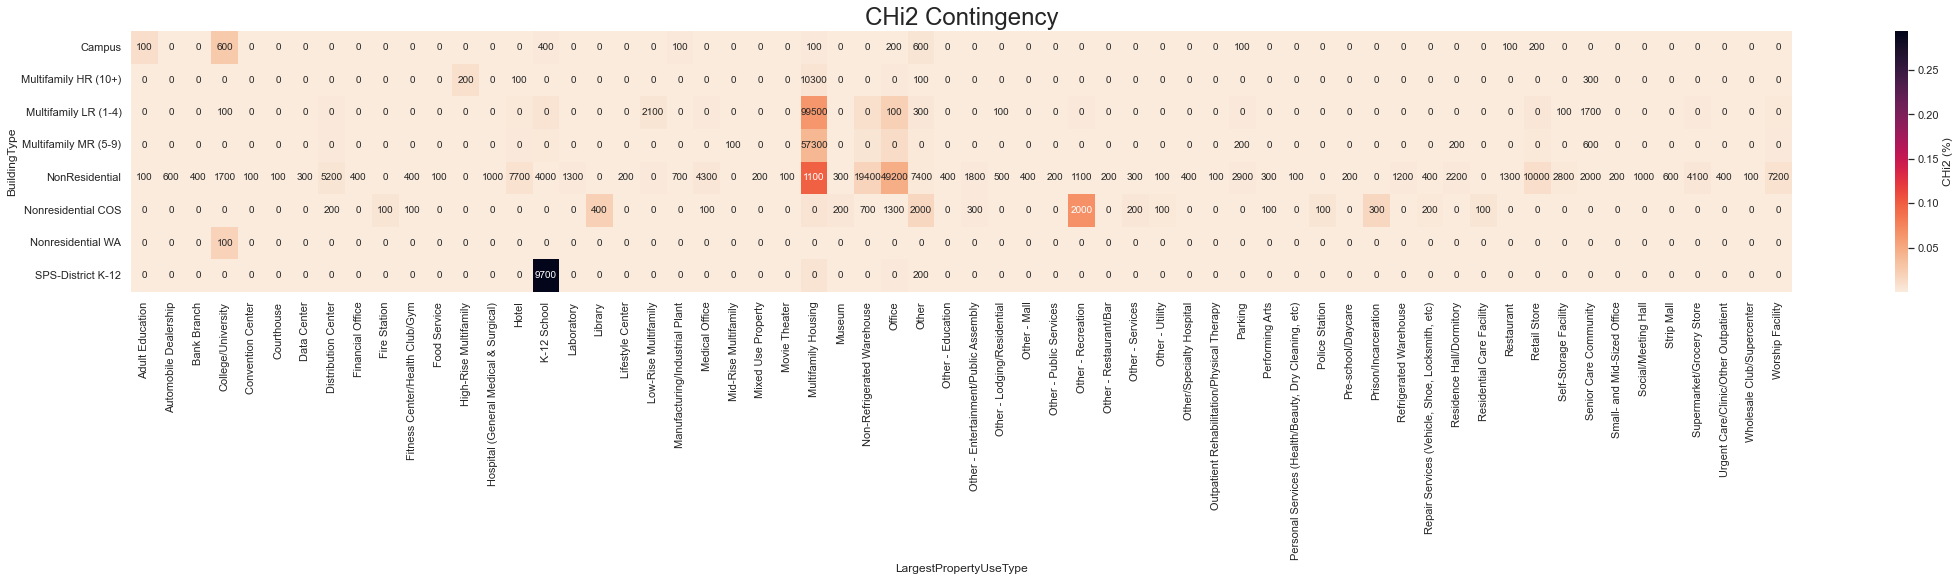

In [178]:
chi2(df, 'BuildingType', 'LargestPropertyUseType')

### 2.3.2- BuildingType & Neighborhood

p-value is:  1.8732591802378166e-165
chi=1062.862687, critical value=114.267868
At 0.05 level of significance, we reject the null hypotheses and accept H1. 
    They are not independent.


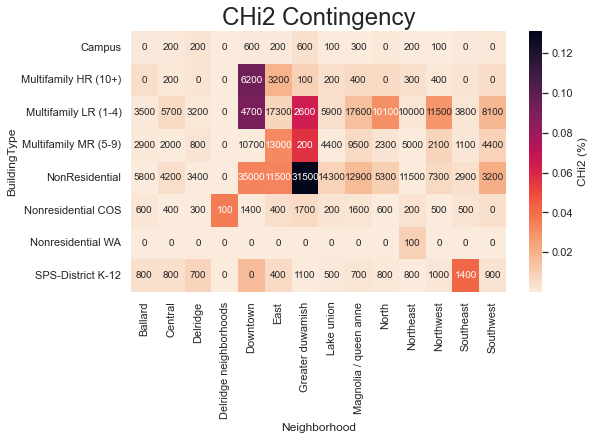

In [179]:
chi2(df, 'BuildingType', 'Neighborhood')

### 2.3.3- LargestPropertyUseType & Neighborhood

p-value is:  2.5960377600445833e-255
chi=3014.462120, critical value=859.622833
At 0.05 level of significance, we reject the null hypotheses and accept H1. 
    They are not independent.


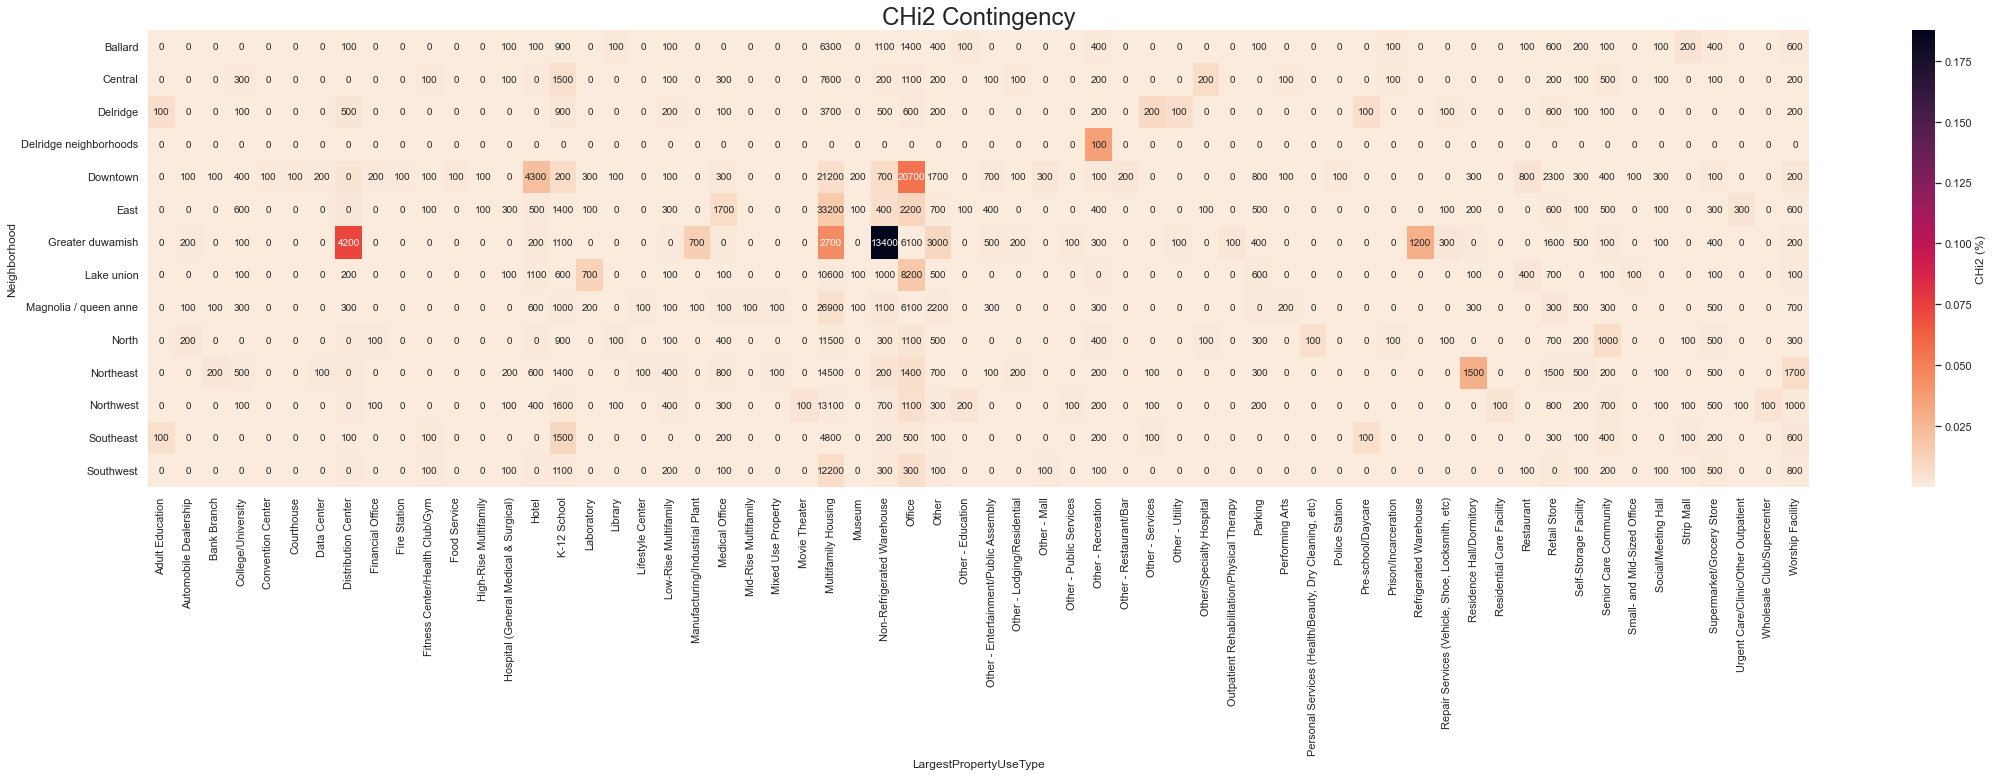

In [180]:
chi2(df, 'Neighborhood', 'LargestPropertyUseType')

Les attributs catégoriels ne sont pas considérés comme totalement indépendants, spécialement <strong>BuildingType</strong> et <strong>Neighborhood</strong>, i.e. certain type de bâtiments sont plus présents dans certains quartiers.
<br/>
Afin de choisir le meilleur traitement de ces attributs on analyse d'abord leur variance (ANOVA).

## 2.4- ANOVA

### 2.4.1- BuildingType

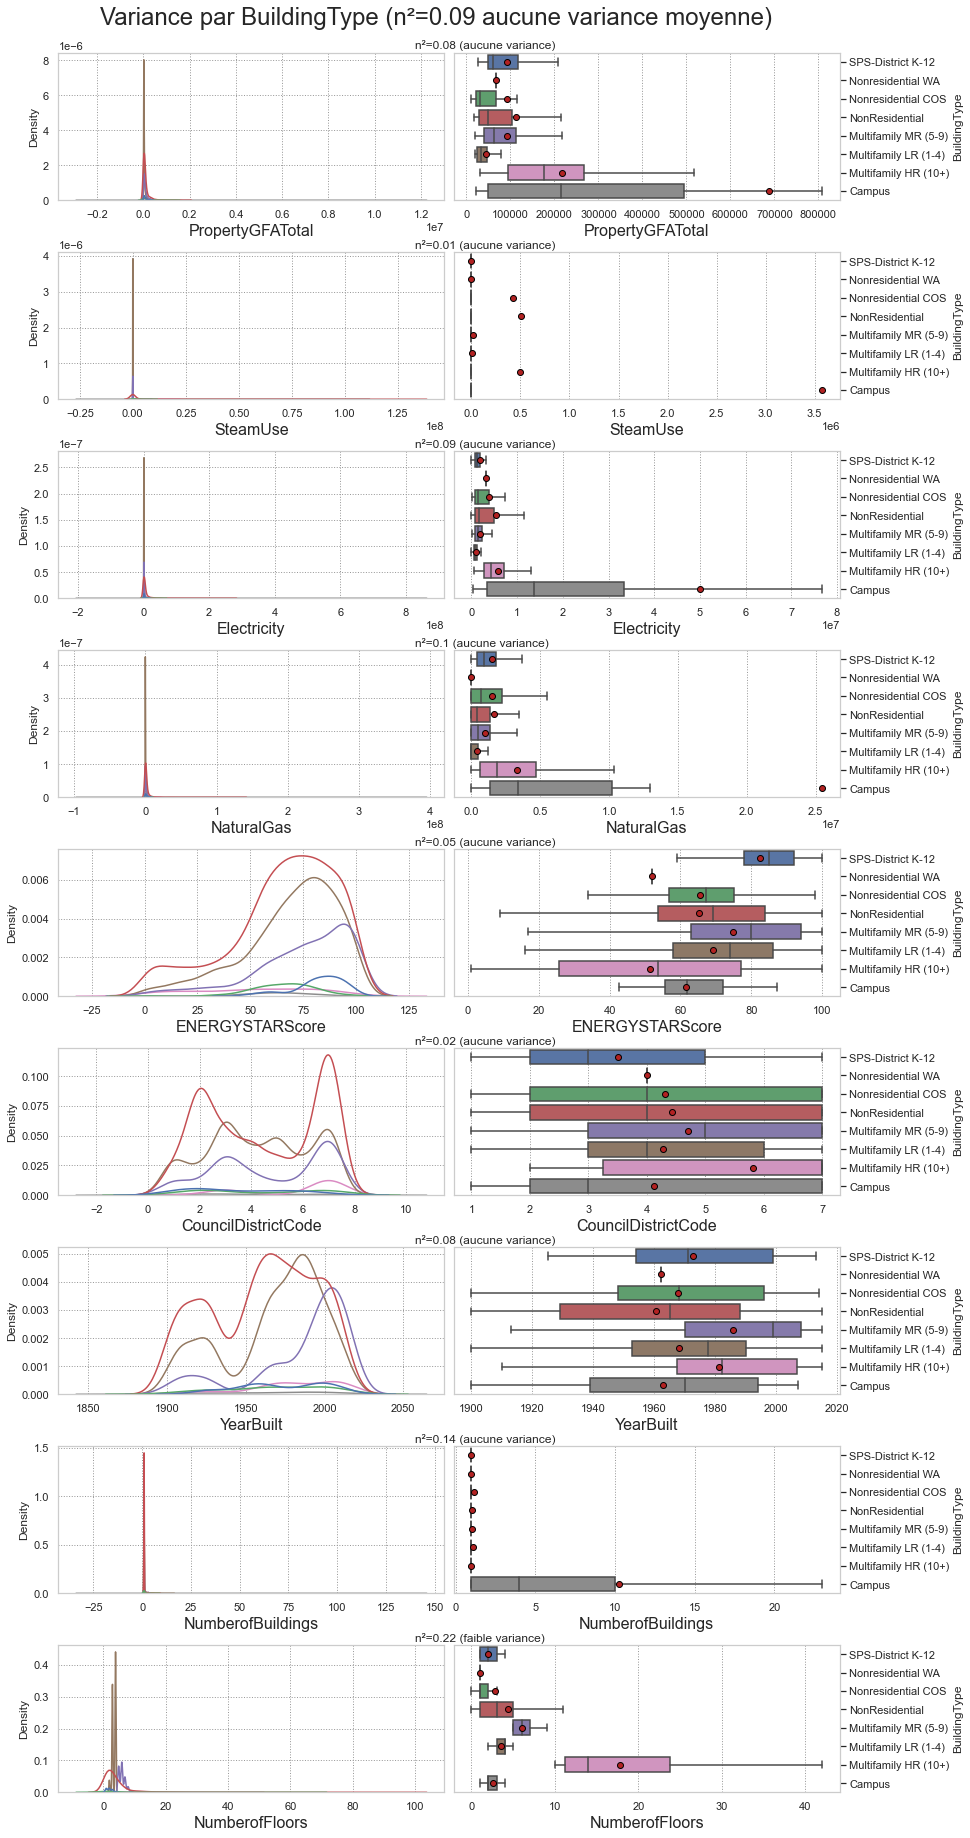

In [181]:
X = 'BuildingType'
ANOVA(df, X, Attributs, yloc=0.9, hspace=0.35, width=7, heigth=0.45)

### 2.4.2- LargestPropertyUseType

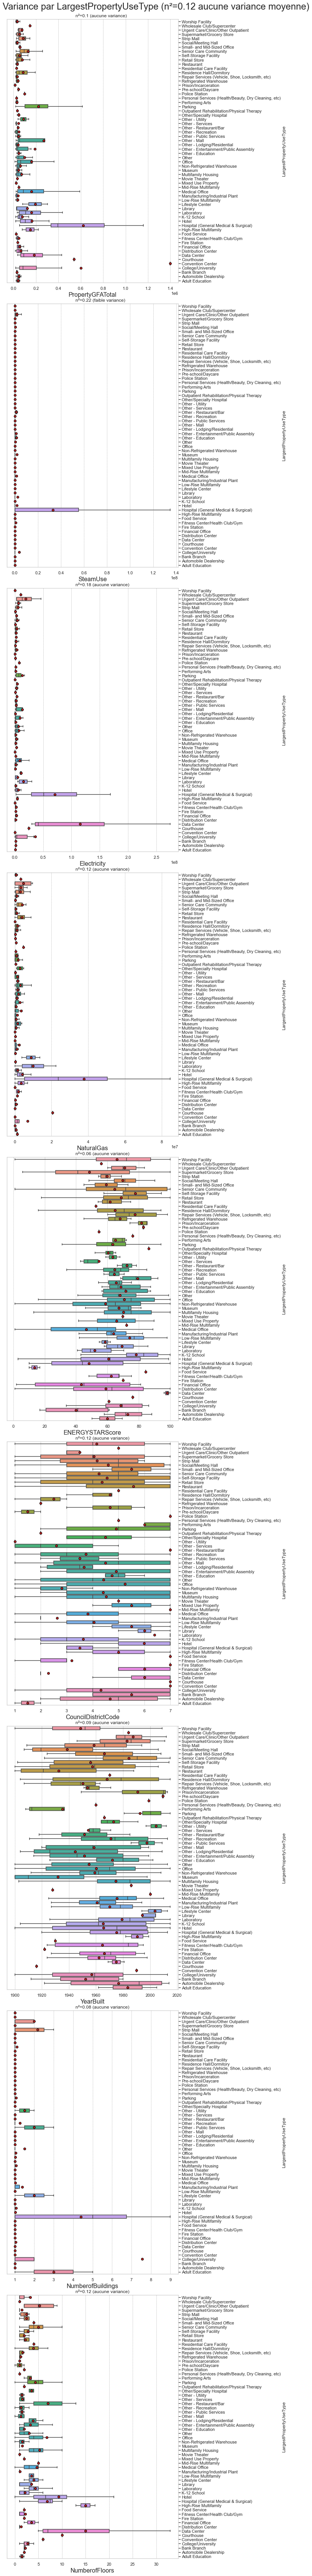

In [182]:
X = 'LargestPropertyUseType'
ANOVA(df, X, Attributs, yloc=0.885, hspace=0.08, width=8, heigth=0.22, display_kde=False)

### 2.4.3- Neighborhood

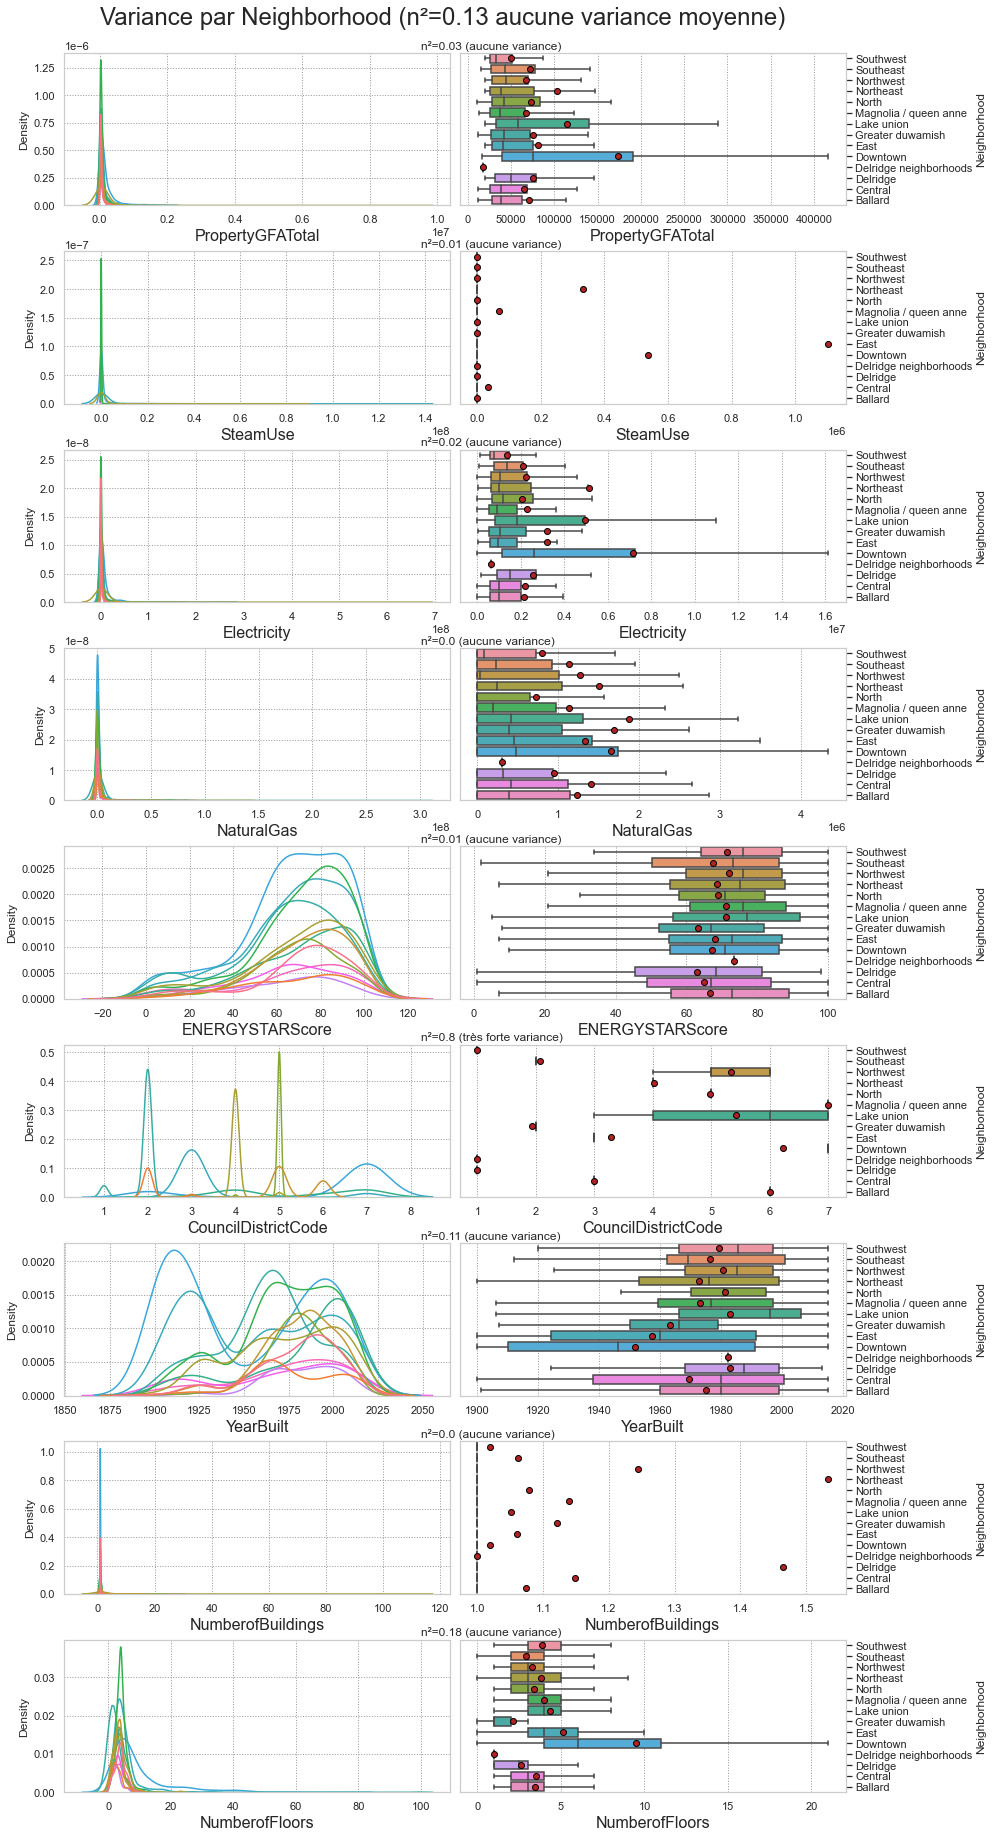

In [183]:
X = 'Neighborhood'
ANOVA(df, X, Attributs, width=7)

Les attributs catégoriels n'ont pas ou peu d’influence sur les attributs continus, exception faite de <strong>Neighborhood</strong> qui a une forte influence sur <strong>CouncilDistrictCode</strong>, car les deux attributs représentent une information sous-jacente similaire : la zone géographique.
<br/>
Il est préférable d’éliminer <strong>CouncilDistrictCode</strong> et <strong>CouncilDistrictCode</strong>, garder pour réduire la complexité des futurs modèles tout en préservant l’information la plus parlante.

In [184]:
# Supprimer CouncilDistrictCode
df = df.drop(columns=['CouncilDistrictCode'])
Attributs.remove('CouncilDistrictCode')

## 2.5- Encodage des Catégories

Encoder/transformer les catégories en valeurs numériques, afin de les rendre exploitable à l'apprentissage des modèles.  

### 2.5.1- Binarisation

Comme introduit lors de l'étude de la corrélation des attributs (2.4), on transforme les attributs représentant l’utilisation d’une source d’énergie (<strong>Electricity</strong>, <strong>NaturalGas</strong>, <strong>SteamUse</strong>) en les binarison : 1 source utilisée, 0 sinon.

In [185]:
df['Electricity'] = df['Electricity'].apply(lambda x : 1 if x>0 else 0)
df['NaturalGas'] = df['NaturalGas'].apply(lambda x : 1 if x>0 else 0)
df['SteamUse'] = df['SteamUse'].apply(lambda x : 1 if x>0 else 0)

In [186]:
categories = colsOfType(df, 'object')
print('Categories:', categories)

Categories: ['BuildingType', 'LargestPropertyUseType', 'Neighborhood']


### 2.5.2- Label Encoding

Premier encodage, par Label Encoding, des catégories. 

In [187]:
df_LE = df.copy()
for categorie in categories:
    df_LE[categorie] = df_LE[categorie].astype('category')
    df_LE[categorie] = df_LE[categorie].cat.codes

### 2.5.3- One Hot Encoding

Deuxième encodage, par One Hot Encoding, des catégories.

In [188]:
# Encodage des colonnes
df_categories = df[categories].copy()
df_OHE = pd.get_dummies(df.copy(), columns=categories)
df_OHE[categories] = df_categories
# Suppression des colonnes
df_OHE = df_OHE.drop(columns=categories)

# 3- Analyse & Transformation des Classes

Analyse et transformation des colonnes à prédire (classes/targets).

## 3.1- Distributions

Etude des distributions.

In [189]:
df[classes].describe()

,TotalEnergy,TotalEmission
count,3.432000e+03,3432.000000
mean,5.309189e+06,119.215956
std,1.595107e+07,533.983944
min,0.000000e+00,0.090000
25%,9.901533e+05,9.568750
50%,1.939984e+06,33.757500
75%,4.404214e+06,91.717500
max,4.716139e+08,16870.980000


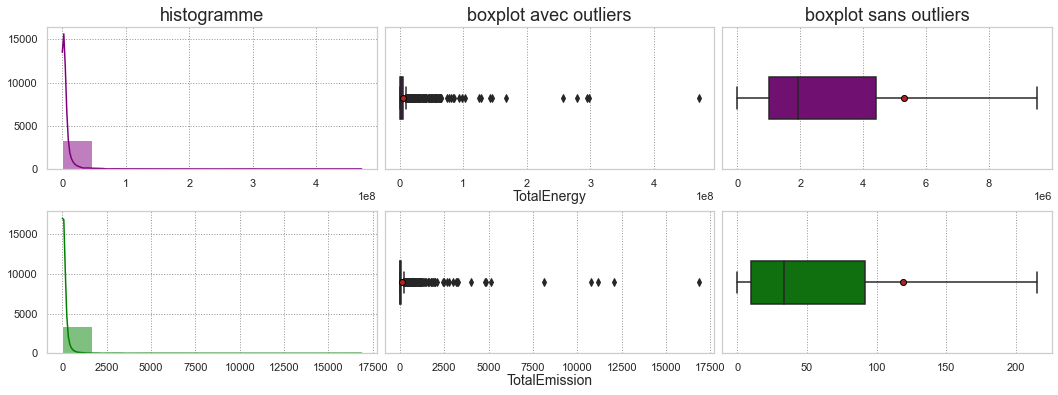

In [190]:
histo_distribution(df[classes])

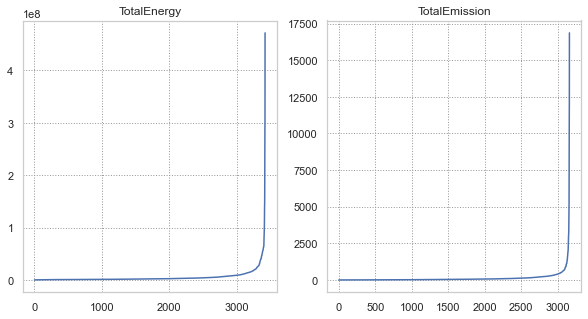

In [191]:
plt.subplots(1, 2, figsize=(10,5))
for i in range(len(classes)):
    plt.subplot(1, 2, i+1)
    plt.plot(sorted(df[classes[i]].unique()))
    plt.title(classes[i])

Les deux classe sont asymétriques (strictement positives), très concentrées sur les valeurs inférieures avec quelques valeurs extrêmes et suivent une progression exponentielles, ce qui crée un déséquilibre très important. 
<br/>
Ce déséquilibre dans les valeurs des classes conduira à une mauvaise performance des modèles, il faut donc corriger ce déséquilibre.

## 3.2- Equilibrage des Classes

L'équilibrage des classes se fait en les passant par la fonction <strong>log</strong>.

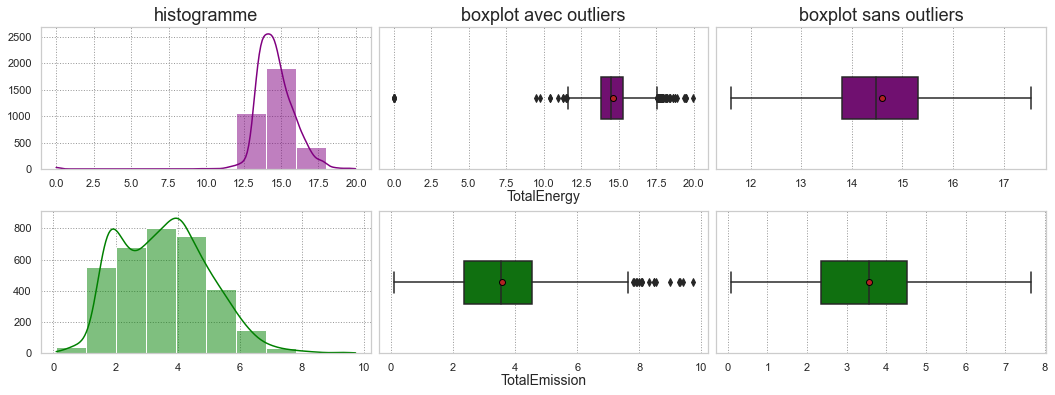

In [192]:
for classe in classes:
    df[classe] = np.log(df[classe]+1)
    df_LE[classe] = np.log(df_LE[classe]+1)
    df_OHE[classe] = np.log(df_OHE[classe]+1)

histo_distribution(df[['TotalEnergy', 'TotalEmission']])

Les deux classes sont maintenant équilibrées, mais il y a des outliers dans les tranches inférieures, on les élimine.

In [193]:
# Suppression des outliers
low_outlier = df[(df[classes[0]]<.1) | (df[classes[1]]<.1)]['OSEBuildingID'].values.tolist()
df = df[~df['OSEBuildingID'].isin(low_outlier)]
df_LE = df_LE[~df_LE['OSEBuildingID'].isin(low_outlier)]
df_OHE = df_OHE[~df_OHE['OSEBuildingID'].isin(low_outlier)]
print(len(low_outlier), 'outliers éliminés.')

10 outliers éliminés.


Réaffichage des distributions pour confirmation.

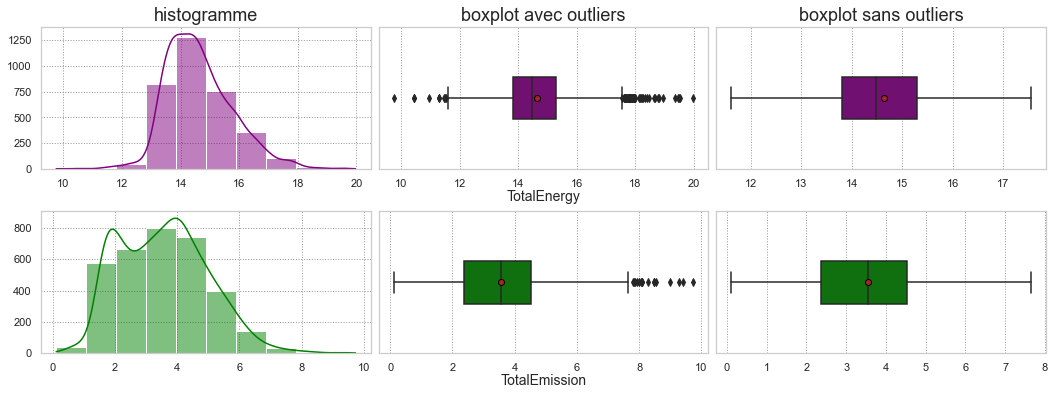

In [194]:
histo_distribution(df[['TotalEnergy', 'TotalEmission']])

Les classes sont maintenant nettoyées.
<br/>
Dans les sections suivantes, on vérifie qu'il n'y a de dépendances fortes entres les attributs et les classes, ce qui conduirait à une fuite des données (Data Leakage) et par conséquent une mauvaise performance des modèles.

## 3.3- Correlations

Etudes des corrélations linéaires entres les attributs numériques et les classes.

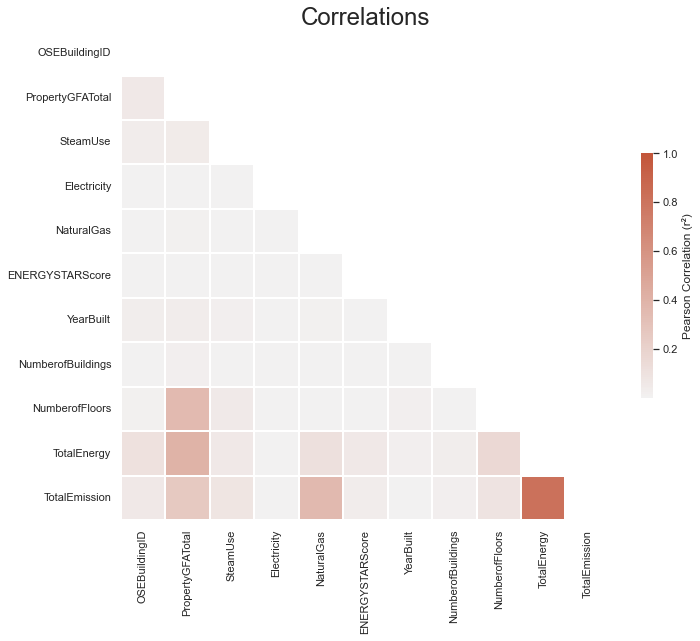

In [195]:
correlation_matrix(df)

Il n'y a pas de corrélations fortes entre les attributs numériques et les classes. Donc pas de risque de fuite des données à ce stade.

## 3.4- ANOVA

Etude de l'impact des attributs catégoriels sur la variance des classes.

### 3.4.1- BuildingType

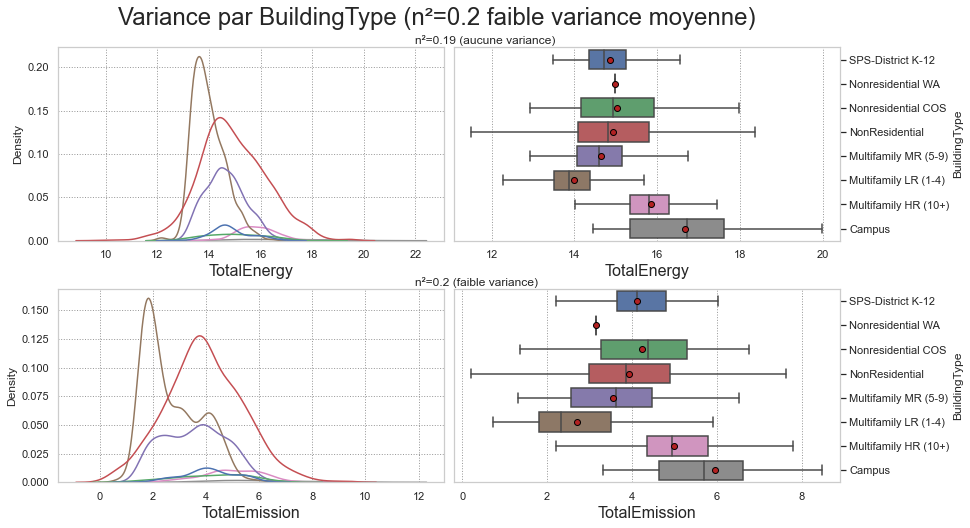

In [196]:
X = 'BuildingType'
ANOVA(df, X, ['TotalEnergy', 'TotalEmission'], yloc=0.95, hspace=0.25, width=7, heigth=0.5)

### 3.4.2- LargestPropertyUseType

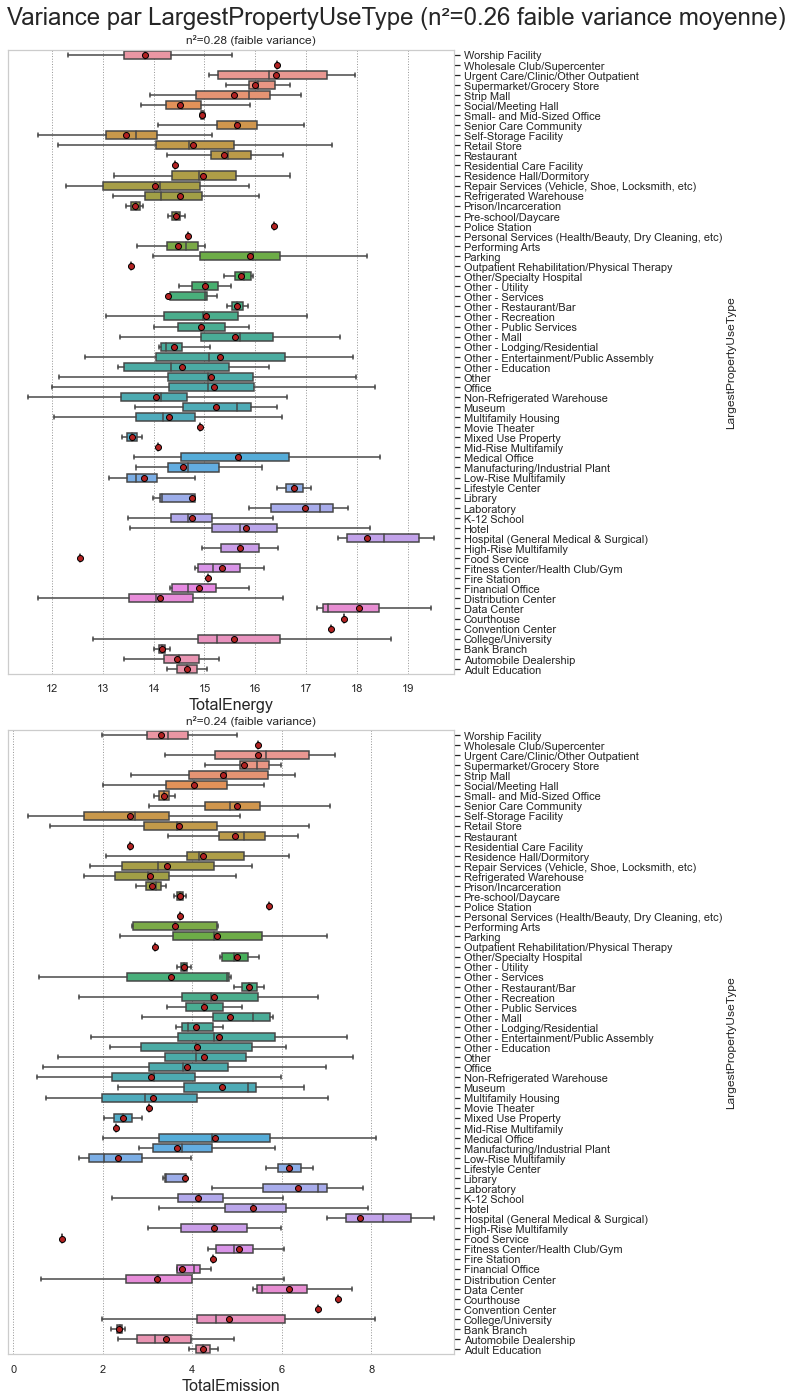

In [197]:
X = 'LargestPropertyUseType'
ANOVA(df, X, ['TotalEnergy', 'TotalEmission'], yloc=0.905, hspace=0.09, width=8, heigth=0.2, display_kde=False)

### 3.4.3- Neighborhood

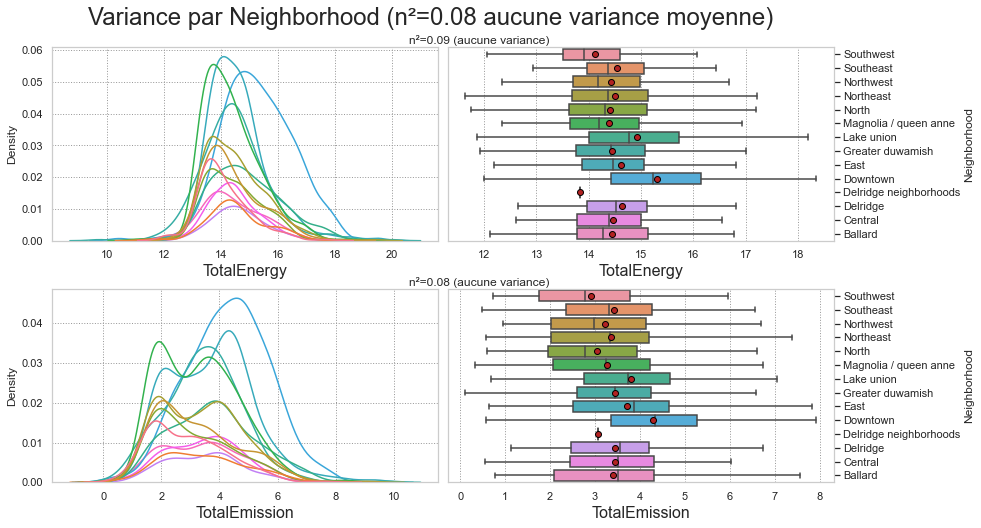

In [198]:
X = 'Neighborhood'
ANOVA(df, X, ['TotalEnergy', 'TotalEmission'], yloc=0.95, hspace=0.25, width=7, heigth=0.3)

<strong>Neighborhood</strong> et <strong>Neighborhood</strong> ont un impact faible mais non négligeable sur la variance des classes, ce qui les rend exploitable par les modèles sans causer de fuite de données.
<br/>
En revanche, l'attribut <strong>Neighborhood</strong> n’a absolument aucun effet sur la variance des classes, ce qui le rend non pertinent pour les modèles. De plus, cet attribut même s'il était pertinent à notre problématique, il serait difficile de proposer des modèles plus généralistes applicables à d'autres villes. Il sera donc supprimé.

In [199]:
df_LE = df_LE.drop(columns=['Neighborhood'])
df_OHE = df_OHE.drop(columns=df_OHE.columns[df_OHE.columns.str.startswith('Neighborhood')])

# 4- Export des Data Sets

Exporter les données avec les différents encodages pour les comparer dans la partie apprentissage.

In [200]:
df.to_csv('building-energy-benchmarking.csv', index=False)
df_LE.to_csv('building-energy-benchmarking-LE.csv', index=False)
df_OHE.to_csv('building-energy-benchmarking-OHE.csv', index=False)